In [2]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
# plt.style.use('bmh')
OUTPUTS_DIR = "./outputs/"
PLT_SAVE_PATH = './images/'

def convert_position(x : int):
    if x == 0:
        return (0,0)
    elif x == 1:
        return (0,1)
    else:
        return (x//2, x%2)

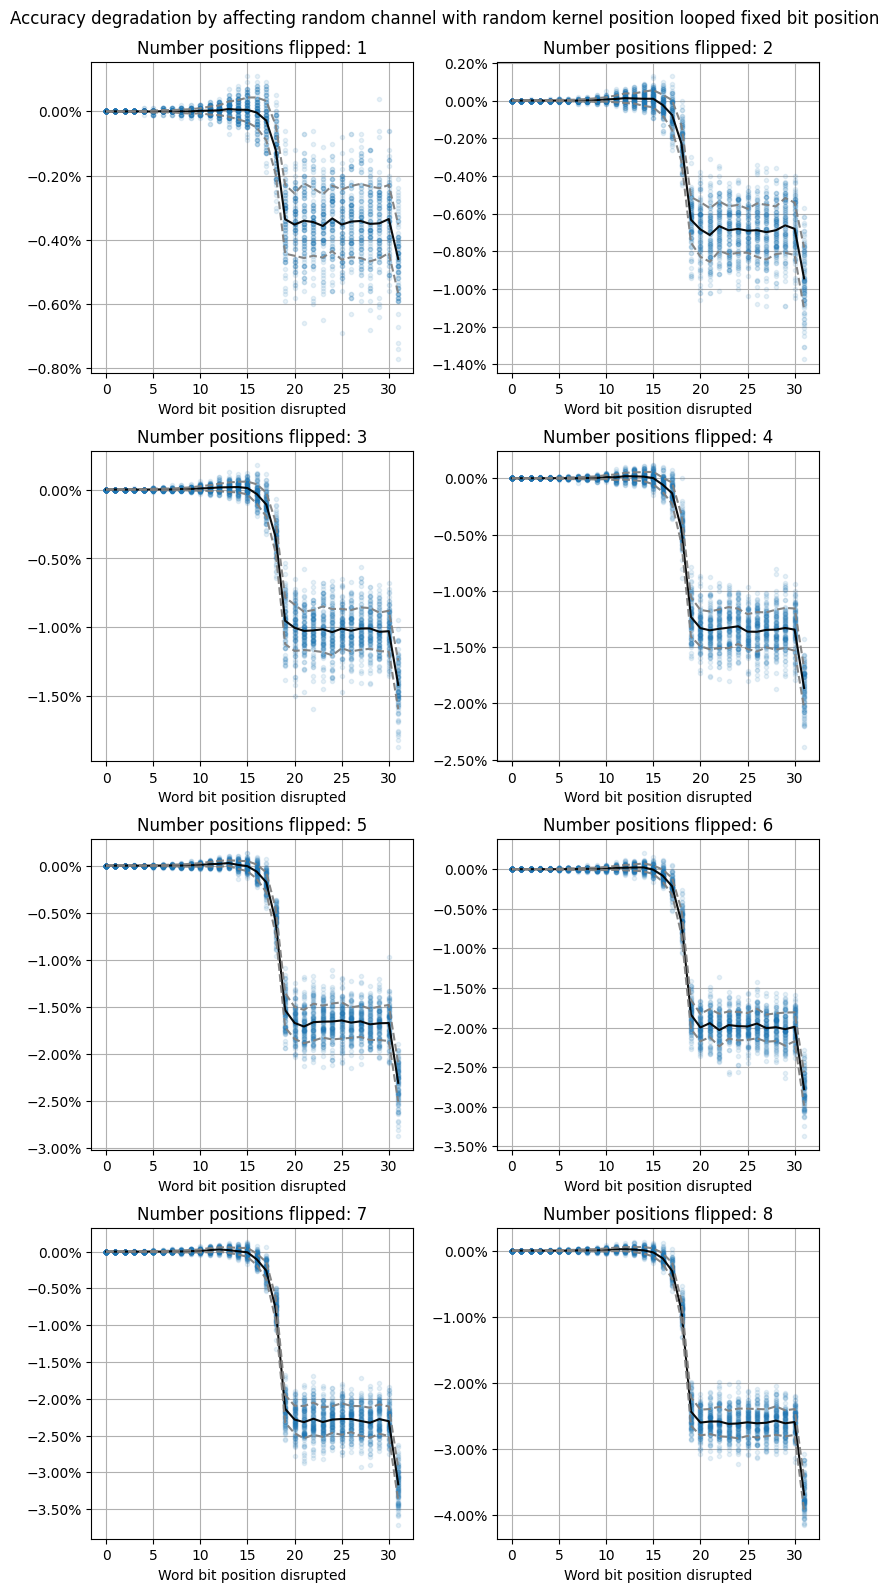

In [42]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative.csv'
SAVE_NAME = 'Output first convolution conservative fixed bit pos accuracy.png'
N_FLIPS = 8
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 16))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Accuracy degradation by affecting random channel with random kernel position looped fixed bit position')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Number positions flipped: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Word bit position disrupted')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

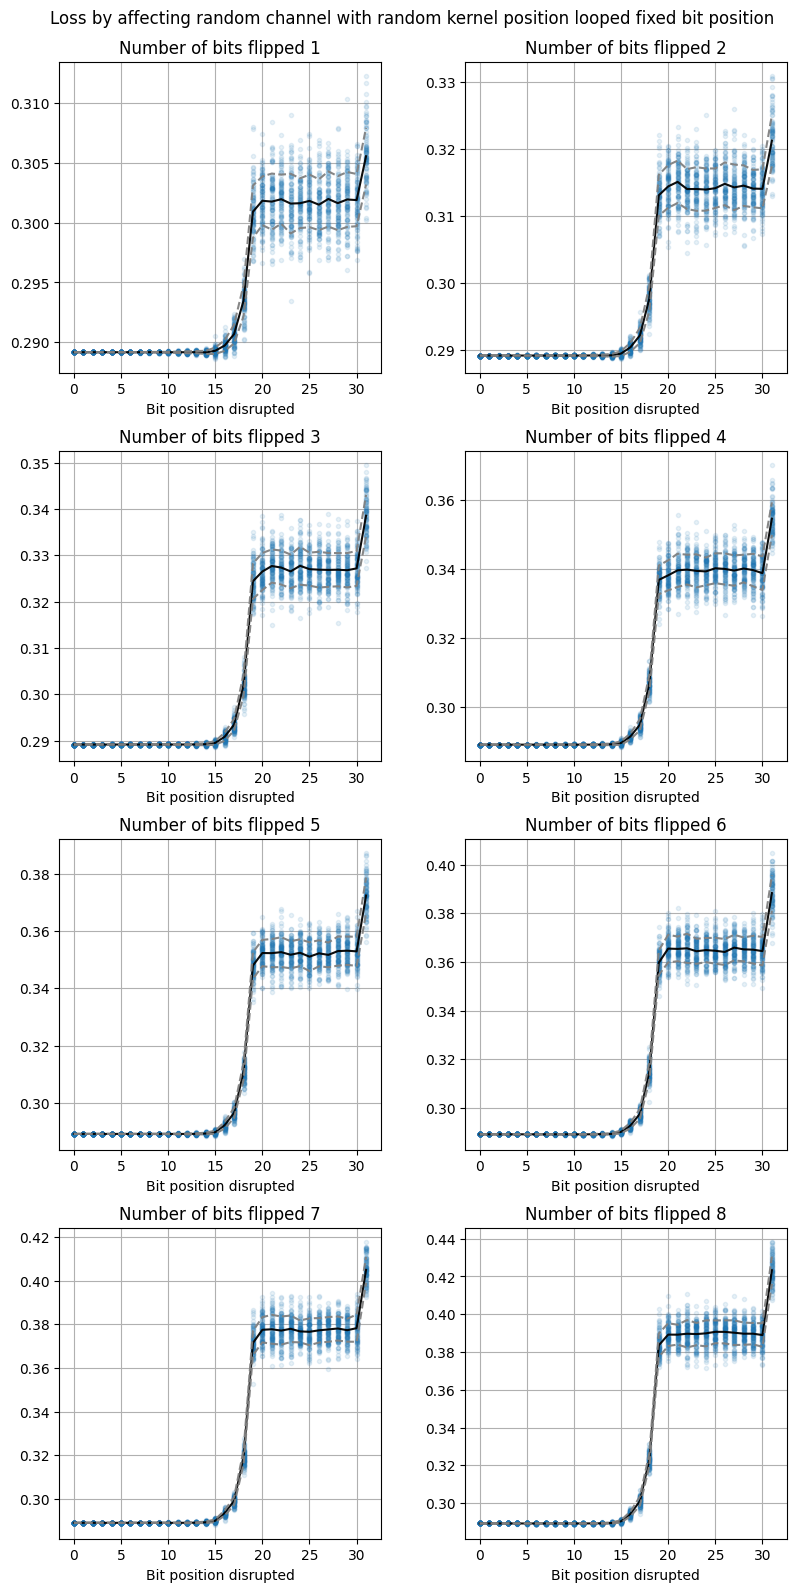

In [36]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative.csv'
SAVE_NAME = 'Output first convolution conservative fixed bit pos loss.png'
N_FLIPS = 8
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 16))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Loss by affecting random channel with random kernel position looped fixed bit position')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Number of bits flipped ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

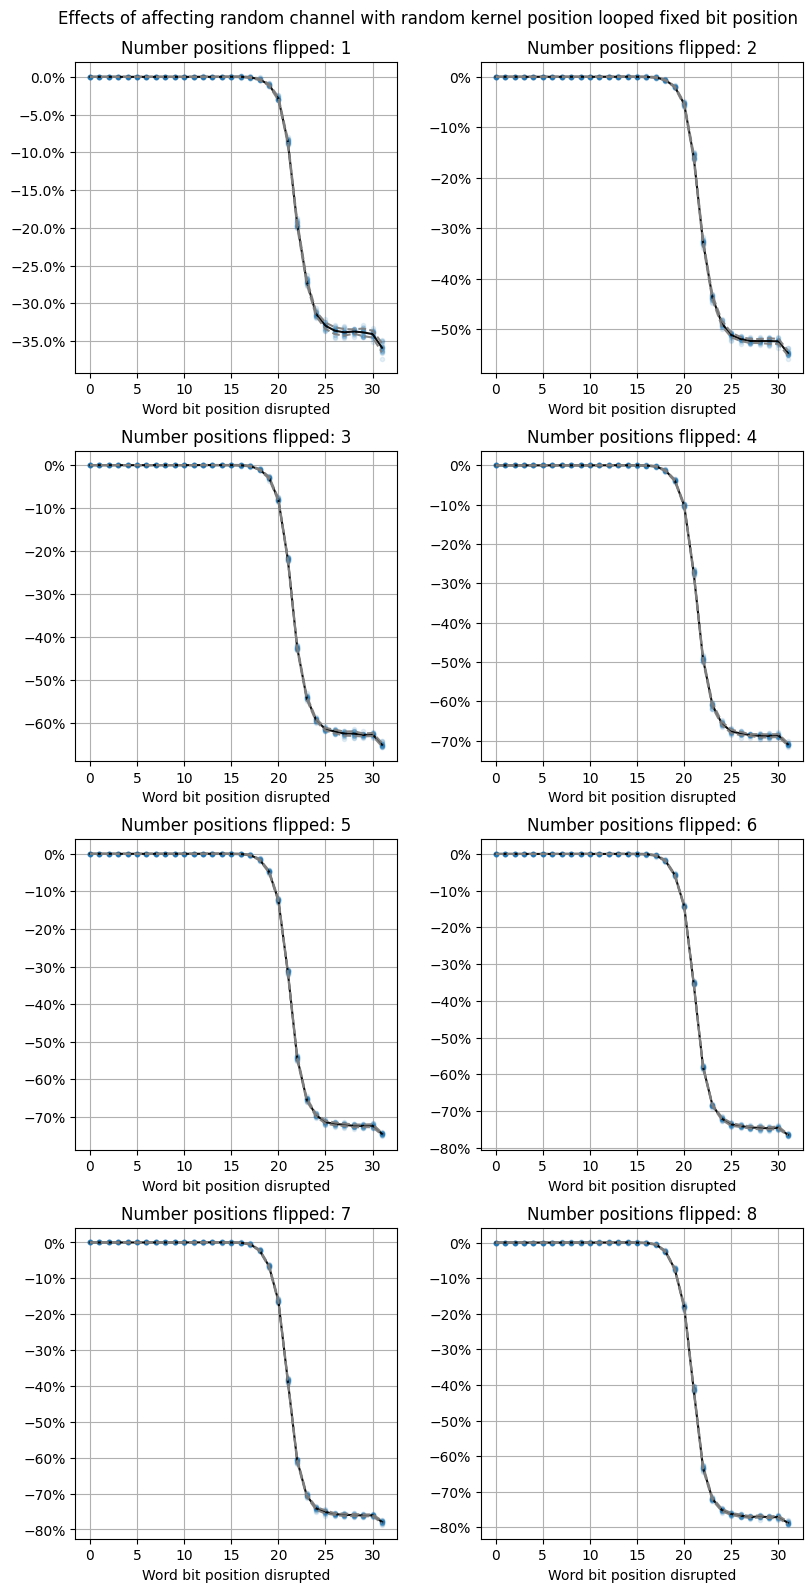

In [37]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative_No_InQuantize.csv'
SAVE_NAME = 'Output first convolution conservative fixed bit pos accuracy no quant.png'
N_FLIPS = 8
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 16))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Effects of affecting random channel with random kernel position looped fixed bit position')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Number positions flipped: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Word bit position disrupted')
    ax[convert_position(i-1)].grid()    
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')


plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

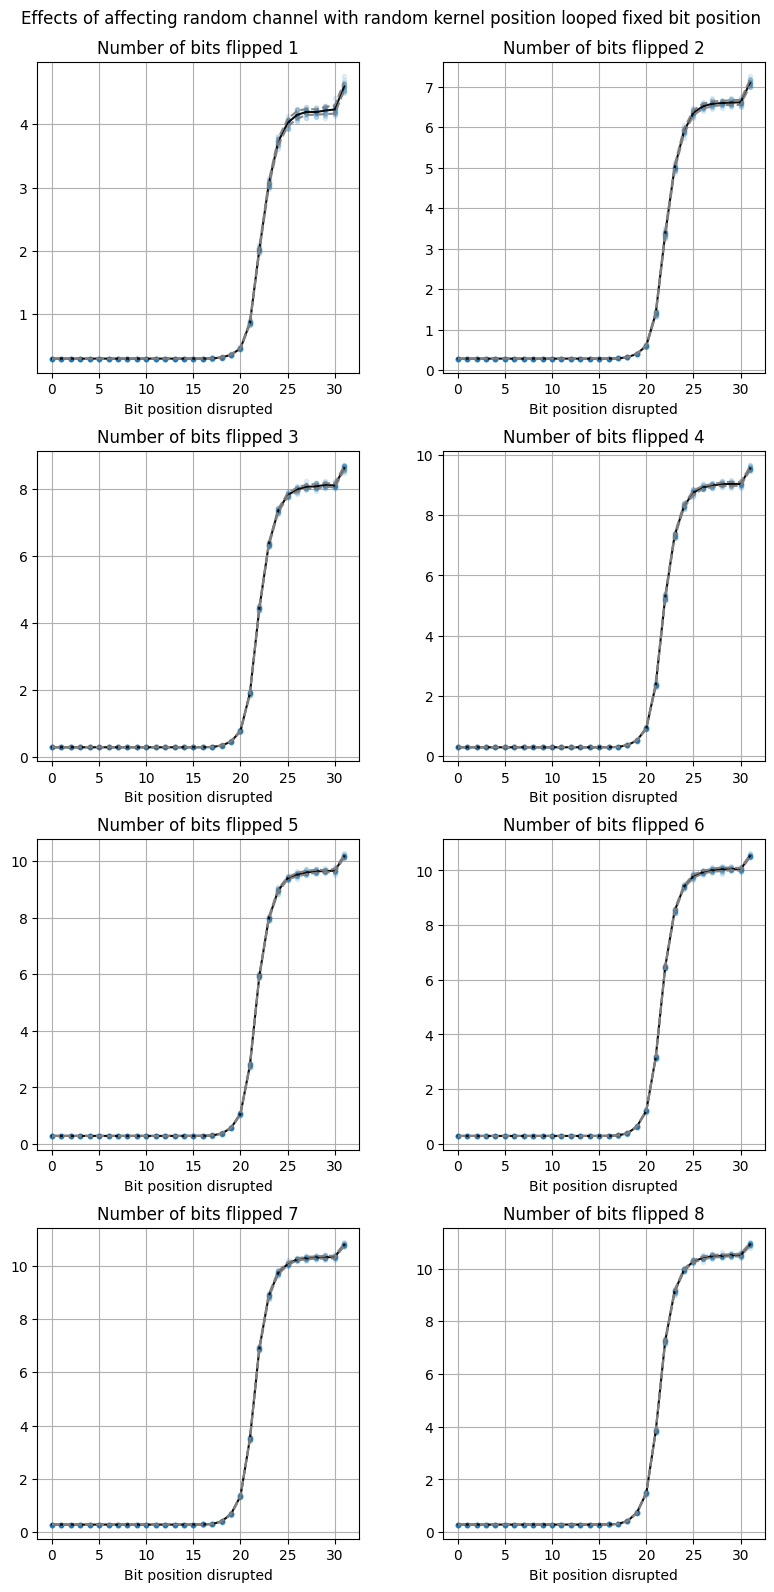

In [38]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative_No_InQuantize.csv'
SAVE_NAME = 'Output first convolution conservative fixed bit pos loss no quant.png'
N_FLIPS = 8
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 16))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Effects of affecting random channel with random kernel position looped fixed bit position')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Number of bits flipped ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

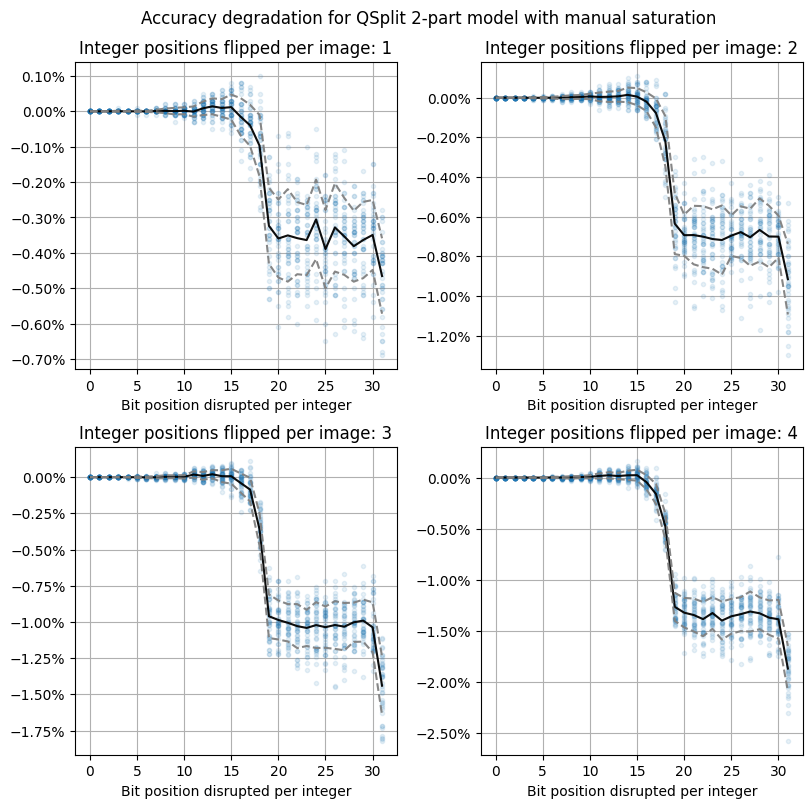

In [39]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quant_Split_ManualSat_2023-06-15.csv'
SAVE_NAME = 'QSplit Manual Saturation Accuracy.png'
N_FLIPS = 4
df = pd.read_csv(SAVE_DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Accuracy degradation for QSplit 2-part model with manual saturation')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

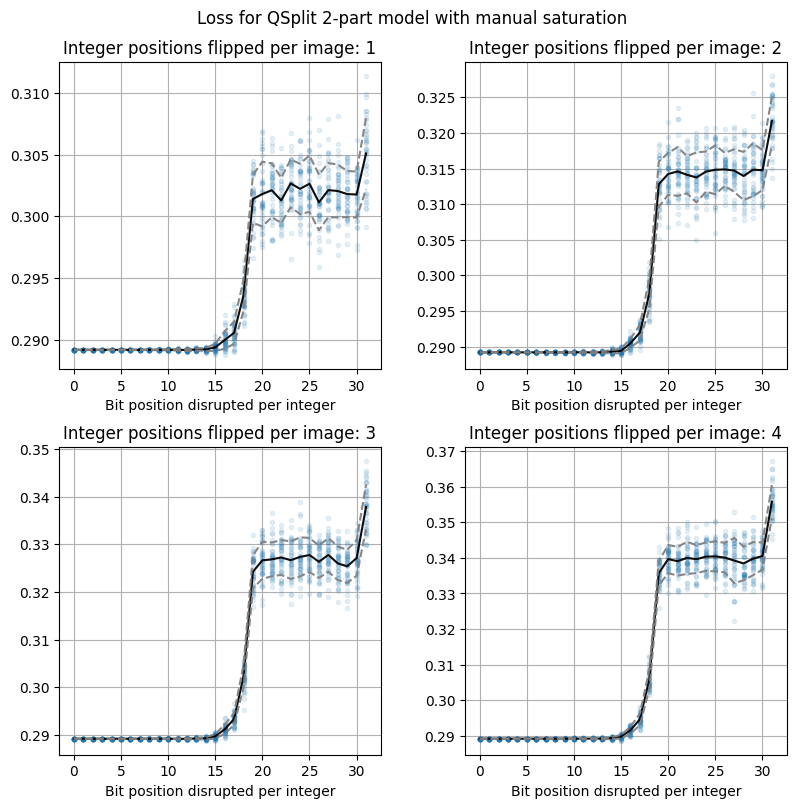

In [40]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quant_Split_ManualSat_2023-06-15.csv'
SAVE_NAME = 'QSplit Manual Saturation Loss.png'
N_FLIPS = 4
df = pd.read_csv(SAVE_DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Loss for QSplit 2-part model with manual saturation')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

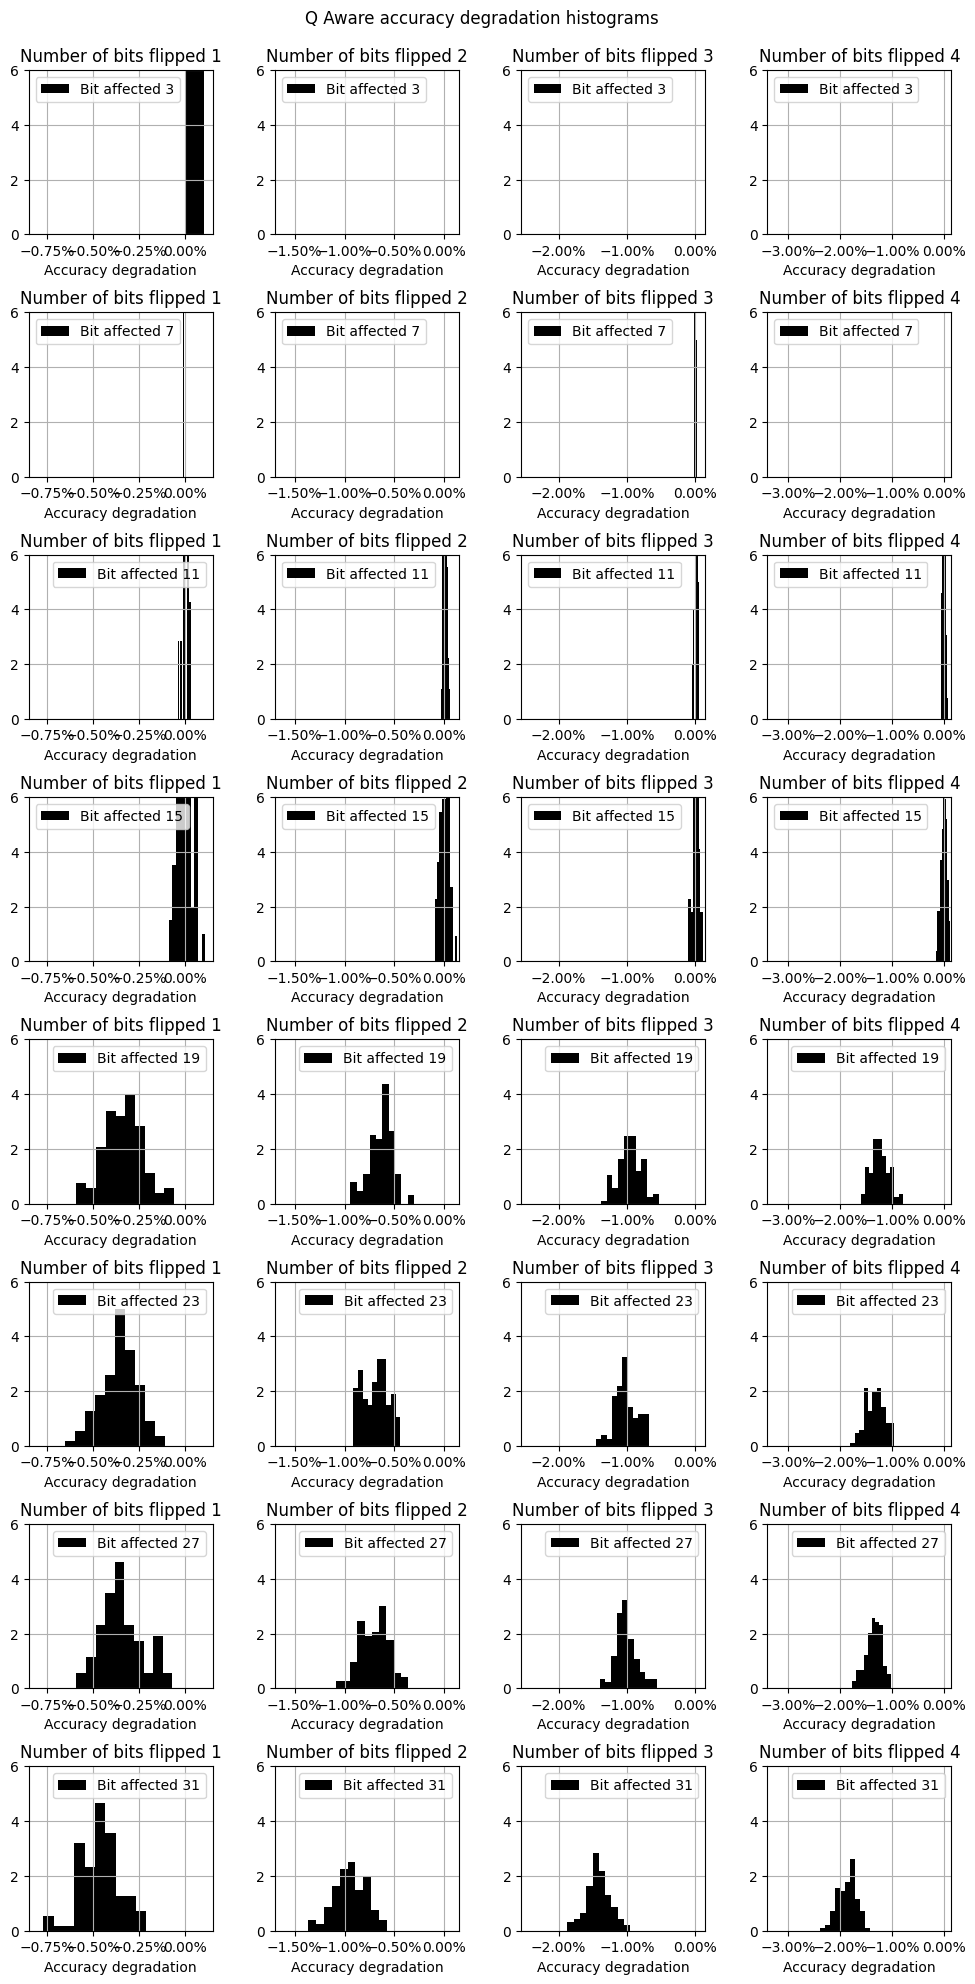

In [61]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative.csv'
SAVE_NAME = 'Histogram accuracy degradation QSplit.png'
N_FLIPS = 4

BIT_STEP = 4
FLIP_STEP = 2
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
BIAS_BIT_WIDTH = 32
# LIMIT_FLIPS = 8
N_GRAPHS = BIAS_BIT_WIDTH//BIT_STEP
# N_FLIPS = LIMIT_FLIPS//FLIP_STEP
fig, ax = plt.subplots(N_GRAPHS, N_FLIPS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 0.96])
fig.suptitle('Q Aware accuracy degradation histograms')

bits_list = np.arange(BIT_STEP - 1, BIAS_BIT_WIDTH, BIT_STEP)
# flips_list = np.arange(1, LIMIT_FLIPS, FLIP_STEP)

for row in range(len(bits_list)):
    for column in range(N_FLIPS):
        ax[row,column].xaxis.set_major_formatter(ticker.PercentFormatter())
        condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == column + 1) & (df['bit_disrupted'] == bits_list[row])
        ax[row,column].hist(pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, density = True, color = 'k')
        ax[row,column].set_xlabel('Accuracy degradation')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(bits_list[row])])
        ax[row,column].set_title('Number of bits flipped ' + str(column + 1))
        ax[row,column].set_xlim([-0.85*(column + 1), 0.15])
        ax[row,column].set_ylim([0, 6])

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

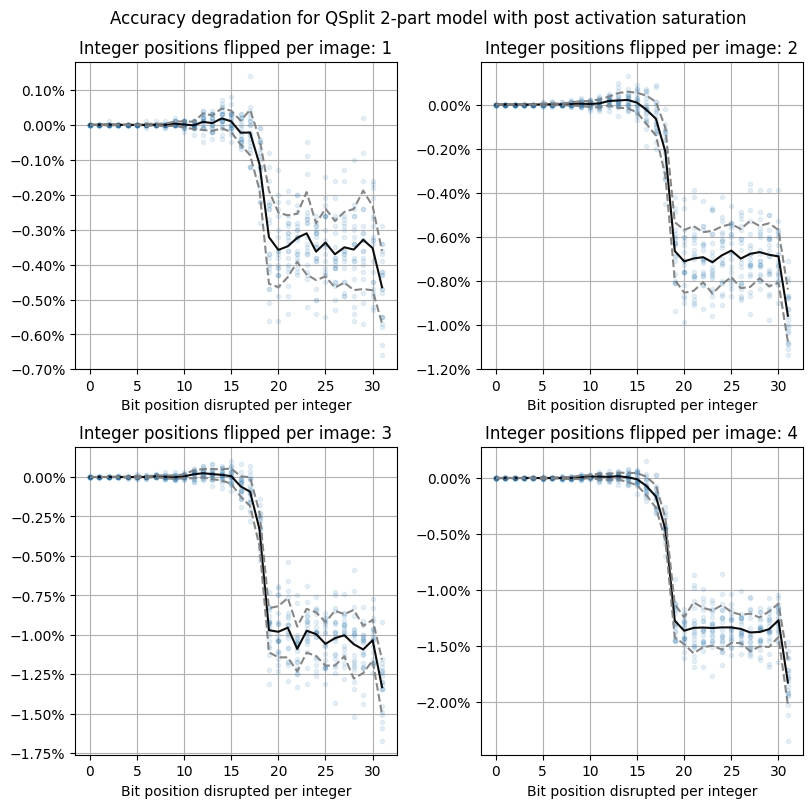

In [3]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'QSplit_multi_relu_2023-06-18_11.csv'
SAVE_NAME = 'QSplit Post Activ Saturation Accuracy.png'
N_FLIPS = 4
df = pd.read_csv(SAVE_DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Accuracy degradation for QSplit 2-part model with post activation saturation')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].grid()
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

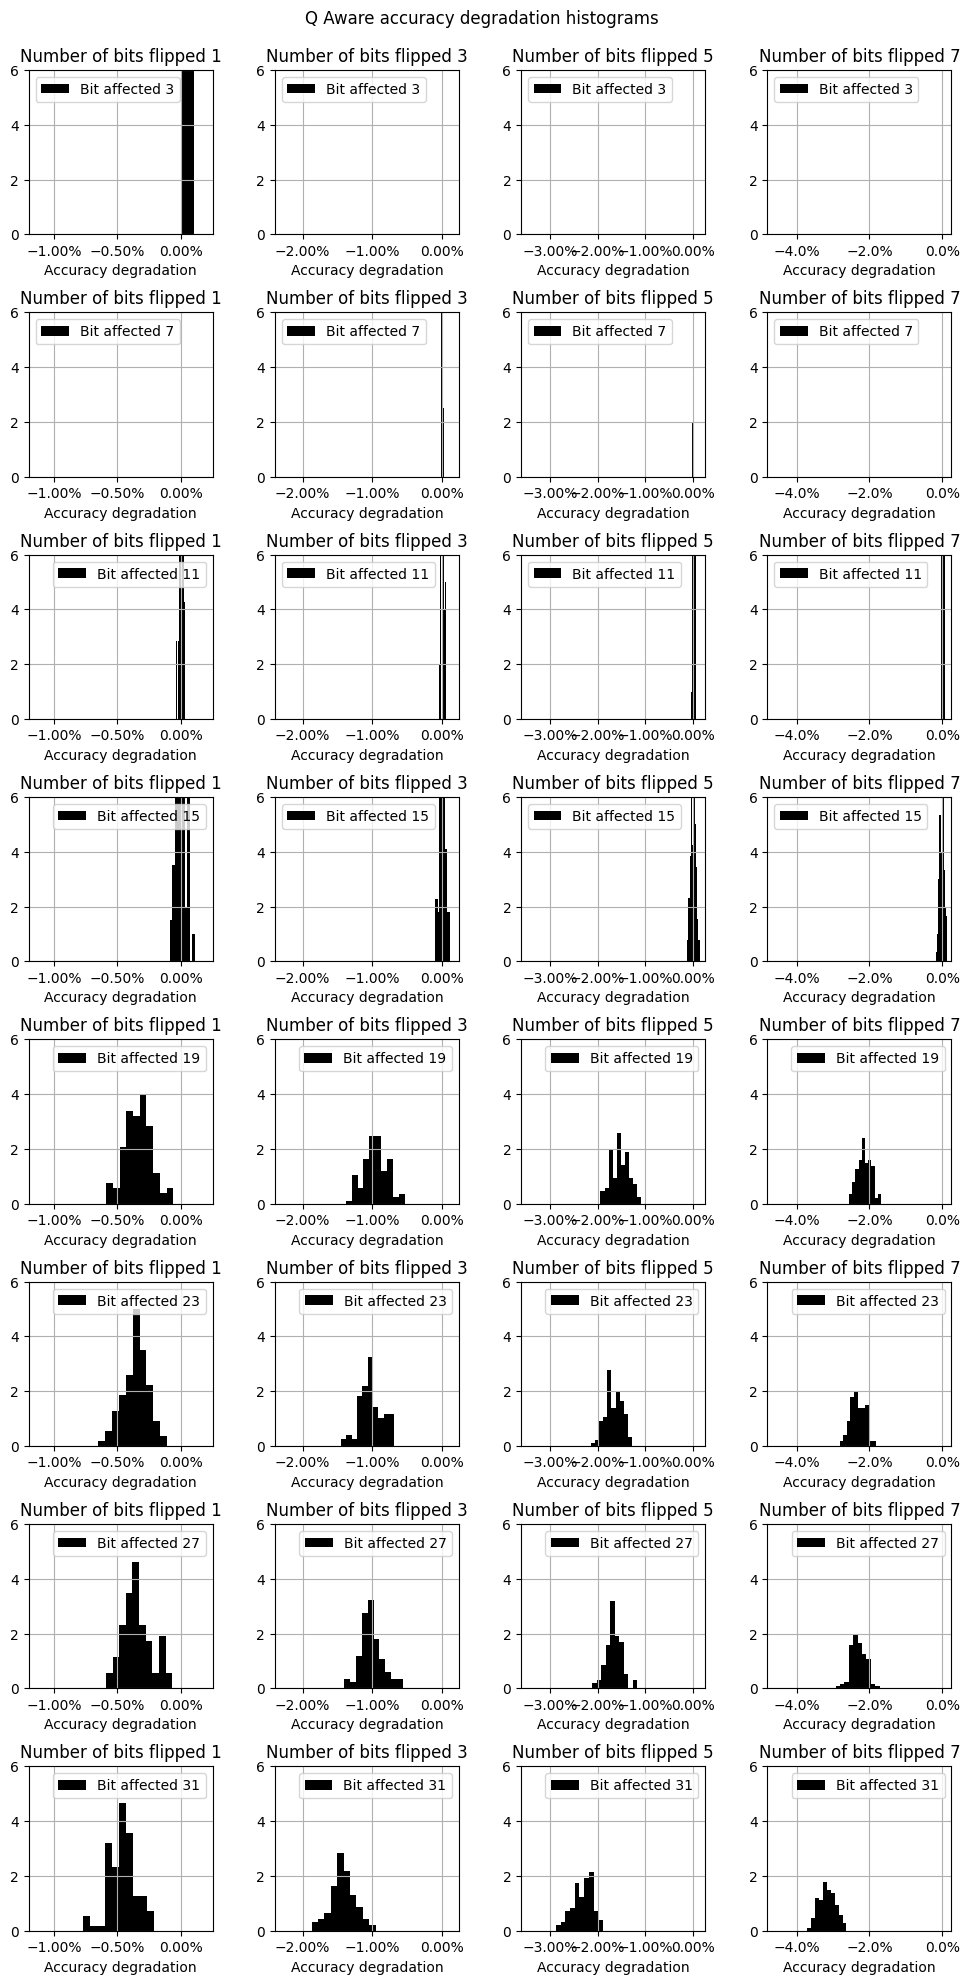

In [47]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative.csv'
SAVE_NAME = 'Histogram accuracy degradation conservative.png'
N_FLIPS = 4

BIT_STEP = 4
FLIP_STEP = 2
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
BIAS_BIT_WIDTH = 32
LIMIT_FLIPS = 8
N_GRAPHS = BIAS_BIT_WIDTH//BIT_STEP
N_FLIPS = LIMIT_FLIPS//FLIP_STEP
fig, ax = plt.subplots(N_GRAPHS, N_FLIPS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 0.96])
fig.suptitle('Q Aware accuracy degradation histograms')

bits_list = np.arange(BIT_STEP - 1, BIAS_BIT_WIDTH, BIT_STEP)
flips_list = np.arange(1, LIMIT_FLIPS, FLIP_STEP)

for row in range(len(bits_list)):
    for column in range(len(flips_list)):
        ax[row,column].xaxis.set_major_formatter(ticker.PercentFormatter())
        condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == flips_list[column]) & (df['bit_disrupted'] == bits_list[row])
        ax[row,column].hist(pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, density = True, color = 'k')
        ax[row,column].set_xlabel('Accuracy degradation')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(bits_list[row])])
        ax[row,column].set_title('Number of bits flipped ' + str(flips_list[column]))
        ax[row,column].set_xlim([-0.6*(flips_list[column] + 1), 0.25])
        ax[row,column].set_ylim([0, 6])

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

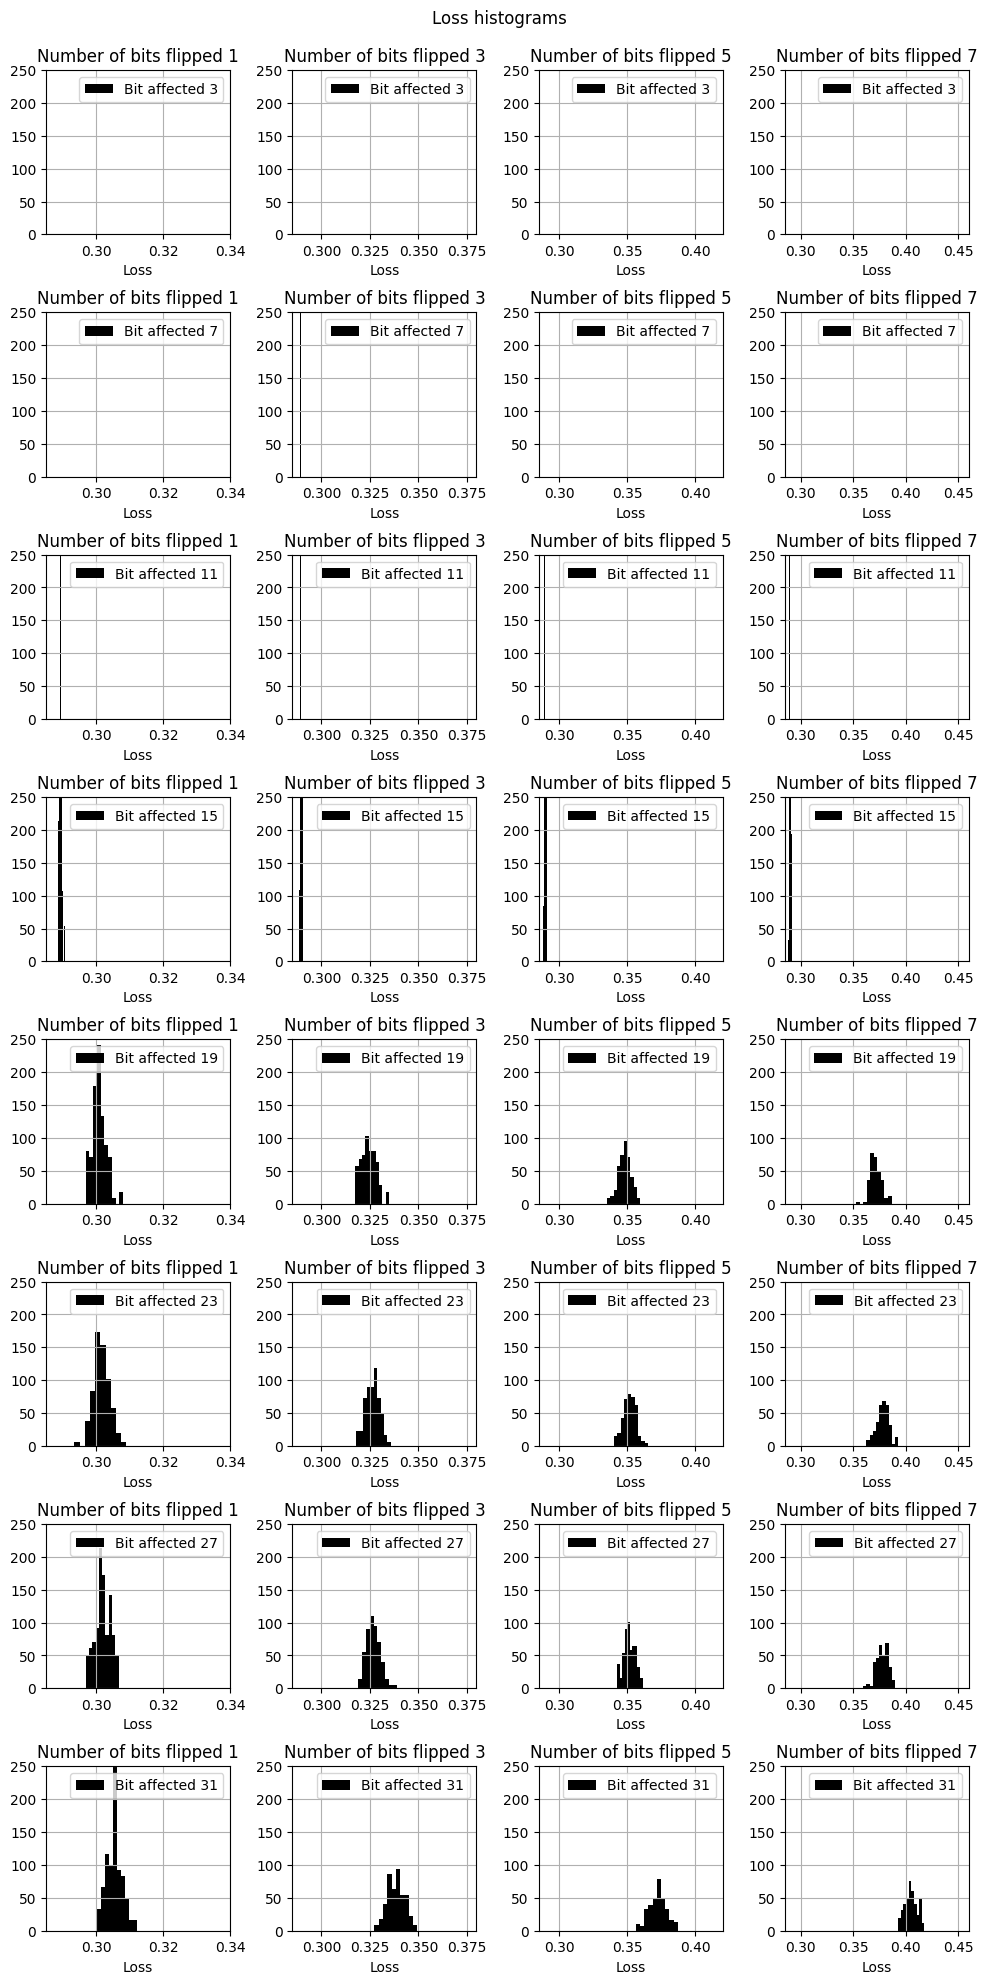

In [24]:
SAVE_DATA_PATH = OUTPUTS_DIR + 'Quantization_Split_Conservative.csv'
SAVE_NAME = 'Histogram loss conservative.png'
BIT_STEP = 4
FLIP_STEP = 2
df = pd.read_csv(SAVE_DATA_PATH, delimiter = ";")

ax : List[List[plt.Axes]]
BIAS_BIT_WIDTH = 32
LIMIT_FLIPS = 8
N_GRAPHS = BIAS_BIT_WIDTH//BIT_STEP
N_FLIPS = LIMIT_FLIPS//FLIP_STEP
fig, ax = plt.subplots(N_GRAPHS, N_FLIPS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 0.96])
fig.suptitle('Loss histograms')

bits_list = np.arange(BIT_STEP - 1, BIAS_BIT_WIDTH, BIT_STEP)
flips_list = np.arange(1, LIMIT_FLIPS, FLIP_STEP)

for row in range(len(bits_list)):
    for column in range(len(flips_list)):
        condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == flips_list[column]) & (df['bit_disrupted'] == bits_list[row])
        ax[row,column].hist(pd.to_numeric(df.loc[condition]['q_aware_test_loss']), density = True, color = 'k')
        ax[row,column].set_xlabel('Loss')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(bits_list[row])])
        ax[row,column].set_title('Number of bits flipped ' + str(flips_list[column]))
        ax[row,column].set_xlim([0.285, 0.02*(flips_list[column] + 1) + 0.3])
        ax[row,column].set_ylim([0, 250])

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

In [ ]:
ax : List[List[plt.Axes]]
N_BITS = 8
N_LAYERS = 4
fig, ax = plt.subplots(N_BITS, N_LAYERS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 0.96])
fig.suptitle('Q Aware accuracy degradation histogram shared axis with 1 bit affected')

for row in range(N_BITS):
    for column in range(N_LAYERS):
        ax[row,column].xaxis.set_major_formatter(ticker.PercentFormatter())
        ax[row,column].hist(df.loc[(df['kernel_index'] == column) & (df['bit_disrupted'] == row)]['q_aware_acc_degradation']*100, color = 'k')
        ax[row,column].set_xlabel('Accuracy degradation')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(row)])
        match column:
            case 0:
                ax[row,column].set_title('First convolutional layer')
                ax[row,column].set_xlim([-2.95, 0.25])
            case 1:
                ax[row,column].set_title('Second convolutional layer')
                ax[row,column].set_xlim([-0.085, 0.125])
            case 2:
                ax[row,column].set_title('Third convolutional layer')
                ax[row,column].set_xlim([-0.095, 0.09])
            case 3:
                ax[row,column].set_title('Dense fully connected layer')
                ax[row,column].set_xlim([-4.75, 0.35])
            case _:
                print("Error no such column found")

plt.savefig(PLT_SAVE_PATH + 'Q Aware degradation histogram shared axis.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [ ]:
ax : List[List[plt.Axes]]
N_BITS = 8
N_LAYERS = 4
fig, ax = plt.subplots(N_BITS, N_LAYERS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 0.96])
fig.suptitle('TF Lite accuracy degradation histogram shared axis with 1 bit affected')

for row in range(N_BITS):
    for column in range(N_LAYERS):
        ax[row,column].xaxis.set_major_formatter(ticker.PercentFormatter())
        ax[row,column].hist(df.loc[(df['kernel_index'] == column) & (df['bit_disrupted'] == row)]['tflite_acc_degradation']*100, color = 'k')
        ax[row,column].set_xlabel('Accuracy degradation')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(row)])
        match column:
            case 0:
                ax[row,column].set_title('First convolutional layer')
                ax[row,column].set_xlim([-4.75, 0.35])
                # ax[row,column].set_xlim([-2.95, 0.25])
            case 1:
                ax[row,column].set_title('Second convolutional layer')
                ax[row,column].set_xlim([-4.75, 0.35])
                # ax[row,column].set_xlim([-0.085, 0.125])
            case 2:
                ax[row,column].set_title('Third convolutional layer')
                ax[row,column].set_xlim([-4.75, 0.35])
                # ax[row,column].set_xlim([-0.095, 0.09])
            case 3:
                ax[row,column].set_title('Dense fully connected layer')
                ax[row,column].set_xlim([-4.75, 0.35])
                # ax[row,column].set_xlim([-4.75, 0.35])
            case _:
                print("Error no such column found")

plt.savefig(PLT_SAVE_PATH + 'TFLite degradation histogram shared axis.png', bbox_inches = 'tight')
plt.show()
plt.close()